**Implementation and evaluation of region growing**

Data Analysis MoBi SS2021, Topic 04: Biomedical image analysis

Tutor: Nicholas Peschke

Group 04: Marie Becker, Ina Jung, Laura Kaschnitz, Johanna Möller

<br>

**Abstract**

xxx

<br>

**Table of content**

1.	Introduction
2.	Datasets – N2DH-GOWT1, N2DL-HeLa and NIH3T3
3.	Imports
4.	Preprocessing <br>
4.1 Clipping <br>
4.2 XXX filter <br>
4.3 Anisotropic diffusion <br>
5.	Seeded region growing algorithm <br>
5.1 Seed selection <br>
5.1.1 Seed selection based on similarities <br>
5.1.2 Seed selection based on Eucledian distance <br>
5.2 Seeded region growing <br>
5.2.1 Seeded region growing based on selected seeds <br>
5.3 Seeded region merging <br>
5.3.1 Seeded region merging based on similarity of intensity <br>
5.3.2 Region merging based on size <br>
6.	Unseeded region growing algorithm

<br>

# Introduction

Image segmentation is an image processing program in the field of data analysis, whose role has become increasingly important in recent years.
It consists in grouping pixels of the image by commonalities of image intensities and thus creating regions of pixels that can be used for data analysis and evaluation.
In this way, image content can be simplified, and its representation can be modified by using methods like thresholding, boundary or region-based segmentation or hybrid techniques.
Image segmentation is often the first step in image analysis. It is widely used, especially in the medical field, but also in the processing of geographical data.

Region growing is a subset of the hybrid techniques of image segmentation which can be used for cell nuclei segmentation.

This class of methods can be further subdivided into seeded and unseeded region growing, while the focus in this project lies on seeded region growing.
Here, selected initial seeds are assigned pixels from the neighborhood if their relative Euclidean distance to the seeds is below a certain threshold.
Subsequently, certain regions are merged to combine similar or small regions (Shih and Cheng, 2005).

After implementing the seeded region growing algorithm, its performance will be evaluated.
For this, result images are compared to already segmented gt-images by using the Dice score.
Finally, seeded and unseeded region growing are also compared with each other using the Dice Score.

<br>

# Datasets – N2DH-GOWT1, N2DL-HeLa and NIH3T3

In order to run and test the implemented seeded region growing algorithm, three different datasets were used: N2DH-GOWT1, N2DL-HeLa and NIH3T3.
The datasets consist of a total of 28 image files, in which different structures of the nucleus were stained using the fluorescent protein GFP.
Attached to the data sets are gt-images where the nuclei have already been segmented.
The images and gt-images of these datasets are often used to evaluate the performance of newly implemented algorithms.

Each dataset has specific challenges that need to be considered.

In the first dataset N2DH-GOWT1, transcription factor Oct 4 was stained by GFP in mouse embryonic stem cells.
The cells are well in focus and do not overlap.
There are no reflections or blurs.
However, the stained cells differ greatly in brightness.
Compared to the other data sets, N2DH-GOWT1 is considered to be the easiest to work with.

N2DL-HeLa shows GFP labeled core histone 2b proteins from human cervical carcinomas.
Overall, the cell density is high whereas the resolution is low, and the cells vary greatly in brightness.
There are no interfering effects due to reflections or blurs.

The last dataset NIH3T3 consists of mouse embryo fibroblasts.
EGFP was used to label the CD-tagged protein.
In NIH3T3 the cells are displayed in a very low contrast and differ strongly in their size and shape.
Very bright regions, presumably caused by reflections from the microscope, probably make this data set the most challenging.

<br>

# Imports

The modules access self-implemented functions in other notebooks or import already stored functions from module packages.
To access them in the final file, the following modules were loaded using the import function:

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import skimage.io as sk
import matplotlib.pyplot as plt
from Functions import image_processing as ip
from Functions import seeded_region_growing as srg
from Functions import unseeded_region_growing as urg
from Functions import seed_detection as sd
from Functions import region_merging as rm
from Functions import old_seeded_region_growing as old_srg
from Functions import old_unseeded_region_growing as old_urg


In order to test the implemented algorithm, initial uploads of the datasets and various modules were made.

The images of the individual datasets were uploaded via GitHub using the Add-File function.
Consequently, they could be accessed on PyCharm through the following function:

In [2]:
image_intensity = sk.imread("Data/N2DH-GOWT1/img/t01.tif")

To display the images, the following function has been implemented:

In [3]:
def show_image(img, x, y):
    """
    shows images with a specific size, in gray and with a colorbar
    :param img: image to be shown (2D array)
    :param x: length of image in x-direction (int)
    :param y: length of image in y-direction (int)
    :return: picture of image in jupyter notebook
    """
    plt.figure(figsize=(x, y))
    plt.imshow(img, "gray")
    plt.colorbar()

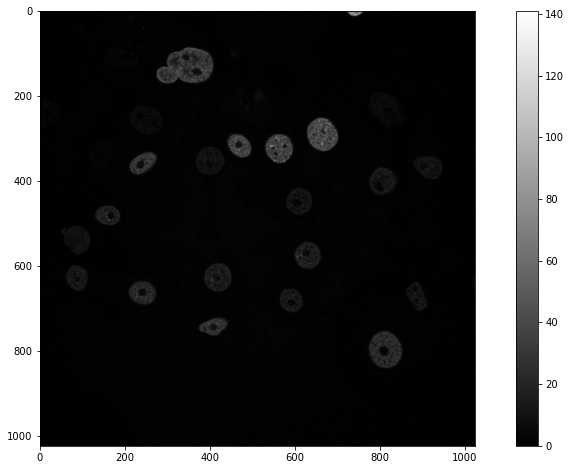

In [4]:
ip.show_image(image_intensity, 15, 8)

# Preprocessing

Preprocessing is an important step in the preparation of data.
Clipping, filtering and other methods can be used to optimize the data to yield better results of the algorithm.
For instance, background noise can be decreased and the image can be reduced to its essential content.
However, it is crucial to avoid losing too much relevant information by overuse of preprocessing.

The algorithm will be applied to both unprocessed and preprocessed images.
By comparing the result images the influence of preprocessing can be tested.

## Clipping

With the clipping method, all intensity values of an image below or above manually defined thresholds will be set to their value.
This allows to combine extreme values and to reduce the intensity spectrum.

For clipping, a pre-implemented method from the numpy module is used:

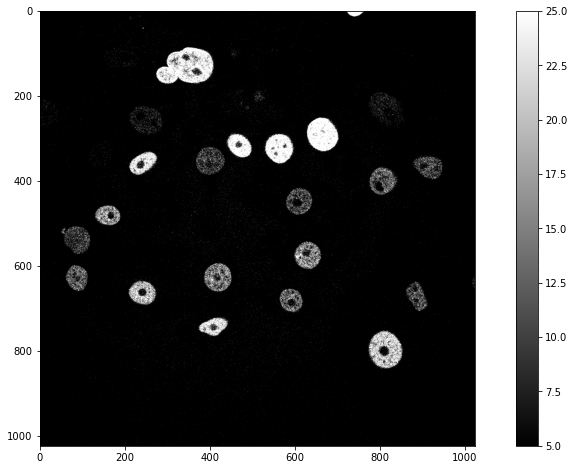

In [5]:
img_clipped = ip.image_clipping(image_intensity, 5, 25)
ip.show_image(img_clipped, 15, 8)

In addition, a separate method was implemented in which the values below or above the thresholds were set to the minimum and maximum intensities of the image.
This variant is intended to increase the contrast of the combined intensities to the remaining:

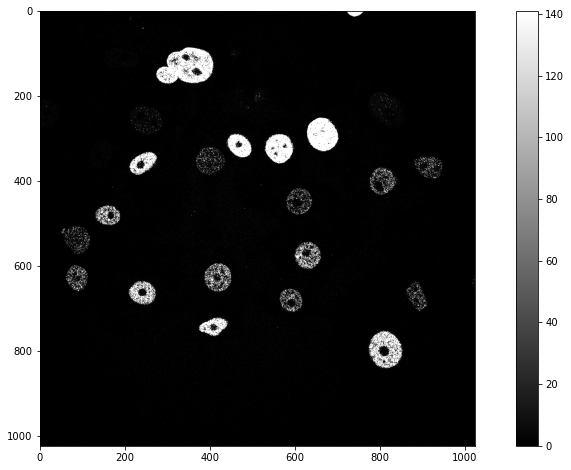

In [6]:
img_clipped_extreme = ip.image_clipping_extreme(image_intensity, 5, 15)
ip.show_image(img_clipped_extreme, 15, 8)

In order to reduce disturbances of the image caused by very bright intensity values, the function remove_bright_spots was implemented.
This will be very useful for the third data set to fade very bright spots into the background using two different thresholds:

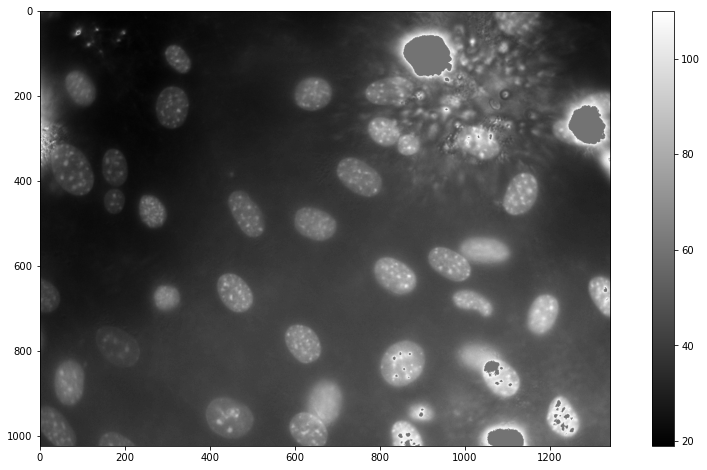

In [7]:
img_removed_spots = ip.remove_bright_spots(sk.imread("Data/NIH3T3/img/dna-33.png"), 110, 60)
ip.show_image(img_removed_spots, 15, 8)

## XX filter

The median filter sorts the intensity values of the specified neighborhood and assigns the median value to the central pixel.
A pre-implemented function of the numpy module has been used:

The Gaussian filter is a linear filter that weights the intensity values of the specified neighborhood with a Gaussian distribution.
Subsequently, the calculated mean value is assigned to the central pixel.
Due to the weighting, the Gaussian filter is an improvement of the Mean filter.
A pre-implemented function of the numpy module has been used:

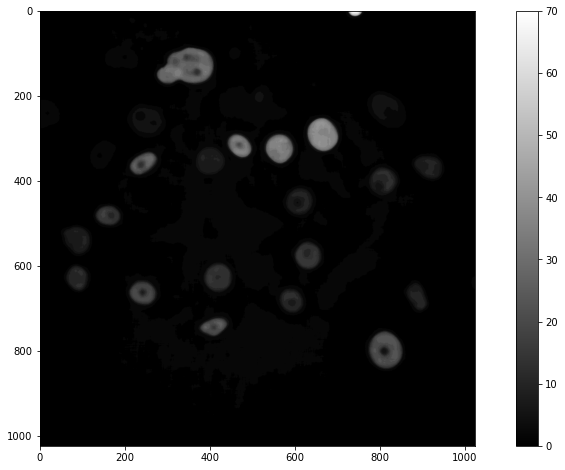

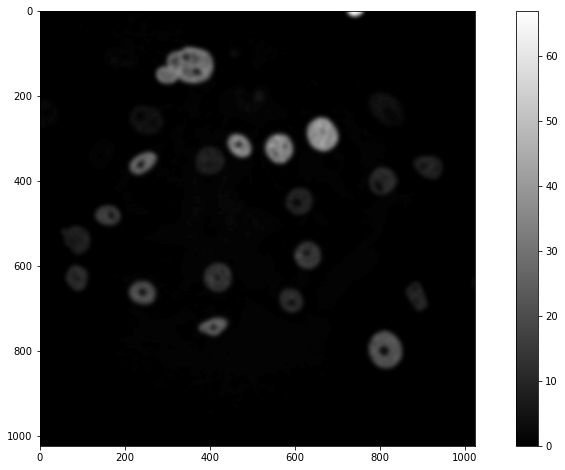

In [8]:
img_median = ip.median_filter(image_intensity, 20)
ip.show_image(img_median, 15, 8)

img_gaussian = ip.gaussian_filter(image_intensity, 5)
ip.show_image(img_gaussian, 15, 8)

## Anisotropic diffusion

Anisotropic diffusion is a filtering technique for reducing image noise while preserving edges (Nair et al., 2019).
The medpy module was used for loading the function:

C:\Users\marie\anaconda3\envs\environmentGroup4\lib\site-packages\medpy\filter\smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
C:\Users\marie\anaconda3\envs\environmentGroup4\lib\site-packages\medpy\filter\smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


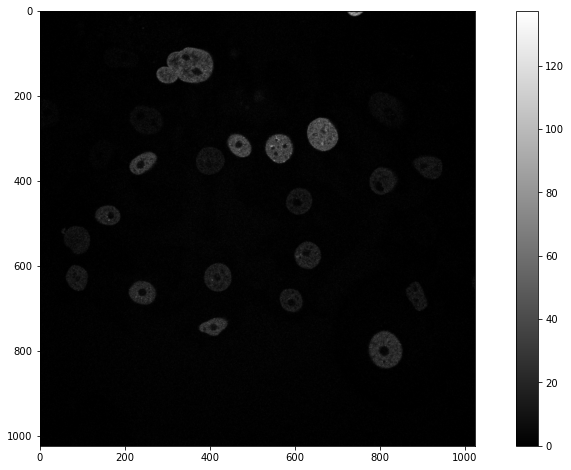

In [9]:
img_anisotropic = ip.anisotropic_filter(image_intensity)
ip.show_image(img_anisotropic, 15, 8)

# Seeded region growing algorithm

Seeded region growing is a sub-method of image segmentation.
It consists of the determination of initial seeds, followed by the assignment of pixels to the seeds, known as seeded region growing.
Regions can then be combined in region merging.
The implementation of the seeded region algorithm is based on the paper of Frank Y. Shih and Shouxian Cheng.

The implemented algorithm is applied to a section of the loaded image for visualization:

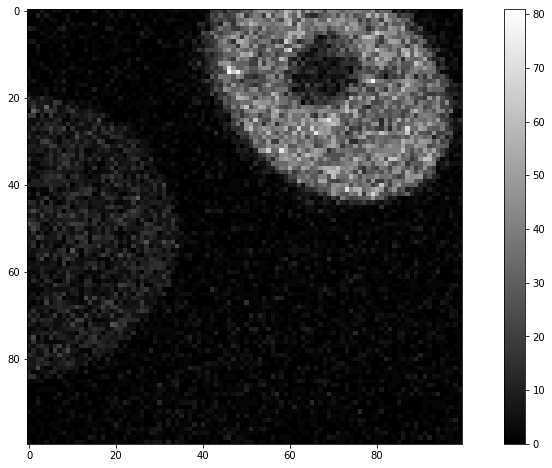

In [10]:
image_intensity_small = image_intensity[300:400, 400:500]
ip.show_image(image_intensity_small, 15, 8)

## Seed selection

In order for pixels to be selected as seeds, they must fulfill two conditions.
One concerns the similarity, the other the Euclidean distance of a pixel to its neighborhood.


### Seed selection based on similarities

To evaluate the similarity, the standard deviation $$\sigma$$ of each pixel to its 3x3 neighborhood is calculated:

$$ \sigma = \sqrt{\left(\frac{1}{9}\sum\limits_{i=1}^{9}(x_i-\overline{x}\right)^2}$$

with $$x_i$$ as pixel intensities and $$\overline{x_i}$$ as the mean intensities of the 3x3 neighborhood of a pixel.
$$\sigma$$ is then normalized by dividing by the maximum value of all calculated standard deviations and the similarity $$s$$ is obtained from the following equation:

$$s=1-\frac{\sigma}{\sigma_{max}}$$

The similarity $$s$$ is then compared to a threshold.
If $$s$$ is greater than the threshold, the pixel can be considered as seed. For this purpose, Otsu thresholding was used to define the threshold value.

### Seed selection based on Eucledian distance

Now all pixels whose similarity $$s$$ is greater than a threshold are further used for seed selection based on Eucledian distance in order to exclude pixels that lie on the border between two regions.
The maximum value $$d_{max}$$ of the Euclidean distances of a pixel to its neighborhood is calculated by:

**Euclidean distance**

$$d_{max}$$ is then also compared to the threshold.
If $$d_{max}$$ is lower than the threshold, the pixel is considered a seed.

The implemented algorithm results in the following seeds:

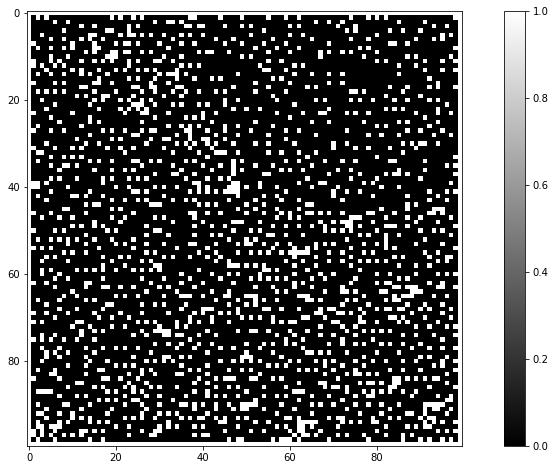

0.24691358024691357


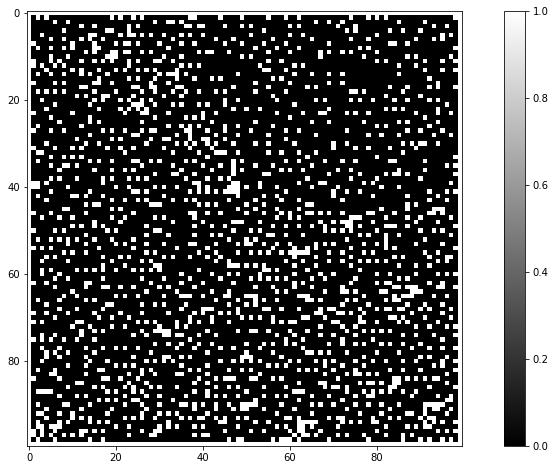

In [17]:
image_seeds = sd.seeds(image_intensity_small, 1)
ip.show_image(image_seeds, 15, 8)


## Seeded region growing

Before starting the region growing algorithm based on the selected seeds, the seeds have to be assigned to regions.

In [22]:
image_regions_from_seeds = sd.seed_merging(image_seeds)

The seeded region growing algorithm labels all pixels to the regions created out of the seeds iteratively.
Thereby, it always labels the pixel with the closest intensity distance to one of its neighboring regions first (Gómez et al., 2007), (Shih and Cheng, 2005).

The algorithm follows the steps below:
1. First, the neighboring pixels to the created regions are selected and stored in four 2d numpy arrays for left, right,
top and bottom neighbors.
1. The distance of these pixels to its neighboring regions is calculated based on previously computed mean intensity
values of the regions.
1. The smallest distance is selected, and the associated pixel position determined. This pixel is now merged to its
neighboring regions.
1. Before the next pixel can be selected, the mean intensity value of the changed region, the arrays of neighboring
regions, and the distances to the changed region need to be recalculated.
1. Again, the most similar pixel is selected and labeled. This procedure is repeated until all pixels are labeled.

1000
2000
3000
4000
5000
6000
7000
8000


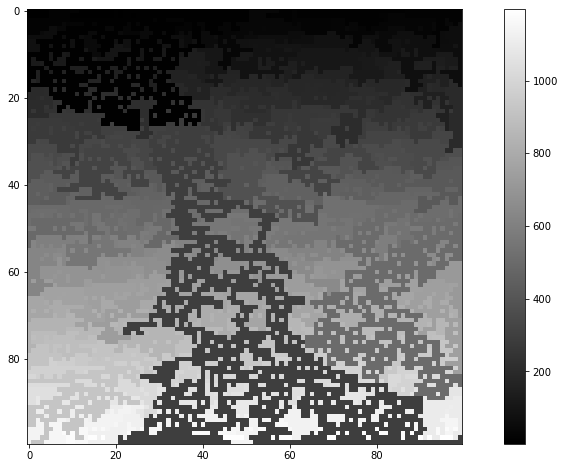

In [19]:
image_regions = srg.region_growing(image_intensity_small, image_regions_from_seeds.copy())
ip.show_image(image_regions,15,8)

## Seeded region merging
In both algorithms, seeded and unseeded region growing too many regions are received due to intensity differences in the background as well as in the cell nuclei.
To solve this over-segmentation a region merging algorithm was implemented.
The received regions are merged based on two criteria: similarity of intensity values and region size.

### Seeded region merging based on similarity of intensity

The first selection criteria is implemented via the following procedure:
1. First the neighboring regions are determined for every region and stored in a 2d numpy array.
1. This is used to calculate the distances between all neighboring regions which are stored in an upper triangle 2d
numpy array. The distance between two regions is calculated using $$dist = \frac{\bar r_m - \bar r_n}{intensity_{max}}$$.
1. Then the most similar regions are selected and merged.
1. This procedure is repeated until the distance between the most similar regions is bigger than a threshold. For that, in every
iteration the mean intensity value of the newly merged region, and the distances to its neighboring regions are updated.
The numpy array, in which neighboring regions are stored is updated as well.

### Region merging based on size

Region merging by size follows the steps below:
1. First the size of every region is calculated and stored in a 1d array.
1. The smallest region is selected and compared to a threshold. If it is smaller, the algorithm continues.
1. The previously determined neighboring regions are used to find out the most similar neighboring region by calculating
the distances using the same formula. The selected smallest region is merged to its most similar neighbor.
1. Afterwards, region sizes are updated, the smallest region is recomputed and its size is compared to the threshold.
1. The next most similar neighboring region is determined based on recalculated distances and neighboring regions.
The algorithm stops as soon as the smallest region is bigger than the threshold.




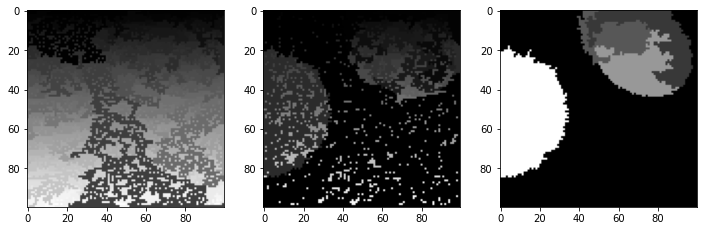

In [23]:
image_for_region_merging = image_regions.copy()
results_region_merging_similarity = rm.distance_merging_while(image_for_region_merging, 0.05, image_intensity_small)
image_rm_similarity, inter_region_neighbors, means = results_region_merging_similarity
image_rm_size = rm.region_merging_size(image_intensity_small, image_rm_similarity.copy(), inter_region_neighbors, means, 500)
ip.show_images_side_by_side(image_regions, image_rm_similarity, image_rm_size)

The figure compares the over-segmented image with the merged image after region merging by intensity similarity and
after complete merging.

# Challenges

## Runtime errors

### Optimizing Seeded Region Growing Algorithm
The paper (Quelle) the used seeded region growing algorithm is based on labels every pixel one by one which leads to
long runtimes. That's why many runtime problems were encountered, especially with the first seeded region growing
algorithm implemented.

In the first region growing algorithm all pixels bordering an existing region are stored in a list. For loops are used
to iterate over this list to find the intensity distance of these pixels to its closest neighboring region. It was
observed that with this algorithm its impossible to segment the whole image in a sensible time with the available
hardware.

Hence, a new algorithm was implemented. It was evaluated to use numpy arrays or pandas data frames to vectorize the
algorithm and decided to use numpy because of faster runtimes. Instead of storing only the smallest distance of every
neighboring pixel to one of its adjacent regions, we are storing every distance. Moreover, the use of for loops was
almost completely reduced, and the algorithm was vectorized. A decrease of runtime by more than 20 times on a part of an
image could be achieved. The improvement on the whole image is even bigger. This allows to execute the region growing
algorithm on a whole image overnight.

In [21]:
%timeit srg.region_growing(image_intensity_small, image_regions_from_seeds.copy())
%timeit old_srg.region_growing(image_intensity_small, image_regions_from_seeds.copy())

1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
6.96 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1000


KeyboardInterrupt: 

### Optimizing Unseeded Region Growing Algorithm
The in the paper (Quelle) proposed unseeded region growing algorithm leads to the same problem. Because every pixel is
selected separately, the runtime of the first implemented algorithm is too long to segment a complete image with our
available hardware.

That's why we rewrote the algorithm similarly to the seeded region growing algorithm. The runtime became nearly 100
faster.

In [ ]:
img_for_urg = image_intensity[300:350, 400:450]
%timeit urg.unseeded_region_growing_algorithm(img_for_urg, (0,0), 5)
%timeit old_urg.old_unseeded_region_growing_algorithm(img_for_urg, (0,0), 5)

### Comparison of Seeded and Unseeded Region Growing

Whilst comparing both algorithms, no significant runtime difference between both algorithms can be discovered. The
runtime difference lies within the $$3 \sigma$$ intervall.

In [22]:
%timeit srg.region_growing(image_intensity_small, image_regions_from_seeds.copy())
%timeit urg.unseeded_region_growing_algorithm(image_intensity_small, (0,0), 5)

1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
1000
2000
3000
4000
5000
6000
7000
8000
7.68 s ± 667 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1000
2000
3000
4000
5000
6000
7000
8000
9000
1000
2000
3000
4000
5000
6000
7000
8000
9000
1000
2000
3000
4000
5000
6000
7000
8000
9000
1000
2000
3000
4000
5000
6000
7000
8000
9000
1000
2000
3000
4000
5000
6000
7000
8000
9000
1000
2000
3000
4000
5000
6000
7000
8000
9000
1000
2000
3000
4000
5000
6000
7000
8000
9000
1000
2000
3000
4000
5000
6000
7000
8000
9000
8.65 s ± 466 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Conclusion
Despite the big runtime improvements, the runtime in both proposed algorithms is still too long. An algorithm which
labels more than one pixel in one iteration could fix this problem. That's why we recommend using another algorithm
of another paper in following research.